In [1]:
import sys
sys.path.append("/home/hugo/projetos-doutorado/Appliance-Energy-Prediction")
import pandas as pd
from pca_fts.PcaWeightedMVFTS import PcaWeightedMVFTS
from pyFTS.benchmarks import Measures
import matplotlib.pyplot as plt
from pyFTS.common import Util
import datetime
import statistics
import math
import numpy as np
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

## Aux functions

In [2]:
def sample_first_prows(data, perc=0.75):
    return data.head(int(len(data)*(perc)))

In [3]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [4]:
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame) 
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)

In [5]:
# def mae(targets, forecasts):
#     sum_error = 0.0
#     for i in range(len(targets)):
#         sum_error += abs(forecasts[i] - targets[i])
#     return sum_error / float(len(targets))
# #     if isinstance(targets, list):
# #         targets = np.array(targets)
# #     if isinstance(forecasts, list):
# #         forecasts = np.array(forecasts)
# #     return np.nanmean(np.abs(np.subtract(targets, forecasts), targets)) * 100

## Dataset Energy Appliance

In [6]:
filename = '/home/hugo/projetos-doutorado/Appliance-Energy-Prediction/data/energydata_complete.csv'
data = pd.read_csv(filename)
data.pop('date')
data.pop('rv1')
data.pop('rv2')
data.dropna(inplace=True)
data = clean_dataset(data)
data

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint
0,60.0,30.0,19.890000,47.596667,19.200000,44.790000,19.790000,44.730000,19.000000,45.566667,...,18.2000,48.900000,17.033333,45.5300,6.600000,733.5,92.000000,7.000000,63.000000,5.300000
1,60.0,30.0,19.890000,46.693333,19.200000,44.722500,19.790000,44.790000,19.000000,45.992500,...,18.2000,48.863333,17.066667,45.5600,6.483333,733.6,92.000000,6.666667,59.166667,5.200000
2,50.0,30.0,19.890000,46.300000,19.200000,44.626667,19.790000,44.933333,18.926667,45.890000,...,18.2000,48.730000,17.000000,45.5000,6.366667,733.7,92.000000,6.333333,55.333333,5.100000
3,50.0,40.0,19.890000,46.066667,19.200000,44.590000,19.790000,45.000000,18.890000,45.723333,...,18.1000,48.590000,17.000000,45.4000,6.250000,733.8,92.000000,6.000000,51.500000,5.000000
4,60.0,40.0,19.890000,46.333333,19.200000,44.530000,19.790000,45.000000,18.890000,45.530000,...,18.1000,48.590000,17.000000,45.4000,6.133333,733.9,92.000000,5.666667,47.666667,4.900000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19730,100.0,0.0,25.566667,46.560000,25.890000,42.025714,27.200000,41.163333,24.700000,45.590000,...,24.7000,50.074000,23.200000,46.7900,22.733333,755.2,55.666667,3.333333,23.666667,13.333333
19731,90.0,0.0,25.500000,46.500000,25.754000,42.080000,27.133333,41.223333,24.700000,45.590000,...,24.7000,49.790000,23.200000,46.7900,22.600000,755.2,56.000000,3.500000,24.500000,13.300000
19732,270.0,10.0,25.500000,46.596667,25.628571,42.768571,27.050000,41.690000,24.700000,45.730000,...,24.7000,49.660000,23.200000,46.7900,22.466667,755.2,56.333333,3.666667,25.333333,13.266667
19733,420.0,10.0,25.500000,46.990000,25.414000,43.036000,26.890000,41.290000,24.700000,45.790000,...,24.6625,49.518750,23.200000,46.8175,22.333333,755.2,56.666667,3.833333,26.166667,13.233333


In [7]:
values = data.values
values

array([[ 60.        ,  30.        ,  19.89      , ...,   7.        ,
         63.        ,   5.3       ],
       [ 60.        ,  30.        ,  19.89      , ...,   6.66666667,
         59.16666667,   5.2       ],
       [ 50.        ,  30.        ,  19.89      , ...,   6.33333333,
         55.33333333,   5.1       ],
       ...,
       [270.        ,  10.        ,  25.5       , ...,   3.66666667,
         25.33333333,  13.26666667],
       [420.        ,  10.        ,  25.5       , ...,   3.83333333,
         26.16666667,  13.23333333],
       [430.        ,  10.        ,  25.5       , ...,   4.        ,
         27.        ,  13.2       ]])

### Dataset Energy Appliance: columns

In [8]:
cols = data.columns
list_cols = list(cols)
list_cols.append('Appliances_t+1')
print(list_cols)

['Appliances', 'lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3', 'RH_3', 'T4', 'RH_4', 'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8', 'RH_8', 'T9', 'RH_9', 'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed', 'Visibility', 'Tdewpoint', 'Appliances_t+1']


### Dataset Energy Appliance: Preprocessing, Lag = 1, t+1

In [9]:
# frame as supervised learning
reframed = series_to_supervised(values, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51]], axis=1, inplace=True)
#reframed.drop(reframed.columns[[0,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51]], axis=1, inplace=True)
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),...,var18(t-1),var19(t-1),var20(t-1),var21(t-1),var22(t-1),var23(t-1),var24(t-1),var25(t-1),var26(t-1),var1(t)
1,60.0,30.0,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,...,48.900000,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,60.0
2,60.0,30.0,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,...,48.863333,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,50.0
3,50.0,30.0,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,...,48.730000,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,50.0
4,50.0,40.0,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,...,48.590000,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0,60.0
5,60.0,40.0,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,...,48.590000,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9,50.0


In [10]:
data = pd.DataFrame(reframed.values,columns=list_cols)
data = clean_dataset(data)
data.head()

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,Appliances_t+1
0,60.0,30.0,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,...,48.900000,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,60.0
1,60.0,30.0,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,...,48.863333,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,50.0
2,50.0,30.0,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,...,48.730000,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,50.0
3,50.0,40.0,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,...,48.590000,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0,60.0
4,60.0,40.0,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,...,48.590000,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9,50.0


## Model: PcaWeightedMVFTS - PCA-MVFTS

In [11]:
pca_wmvfts = PcaWeightedMVFTS(n_components = 2,n_part = 50,endogen_variable='Appliances')

--------------------
training window 0


/home/hugo/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


[ 18:27:43] getting statistics


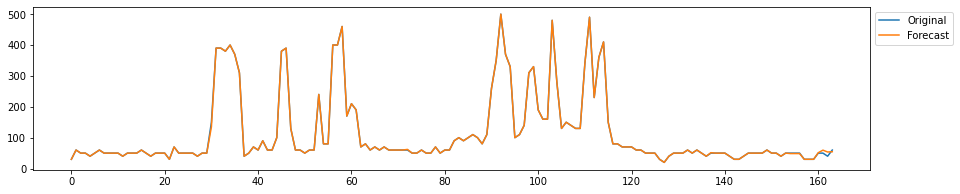

--------------------
training window 657


/home/hugo/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


[ 18:27:44] getting statistics


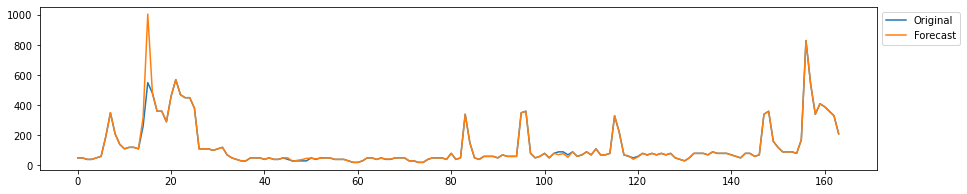

--------------------
training window 1314


/home/hugo/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


[ 18:27:45] getting statistics


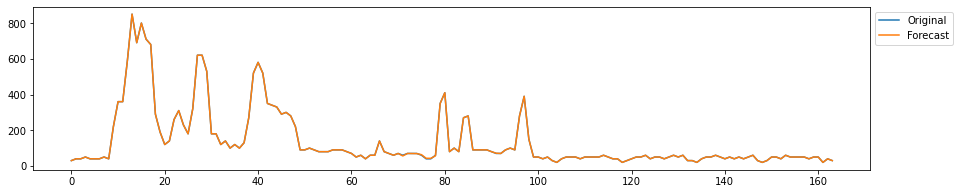

--------------------
training window 1971


/home/hugo/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


[ 18:27:46] getting statistics


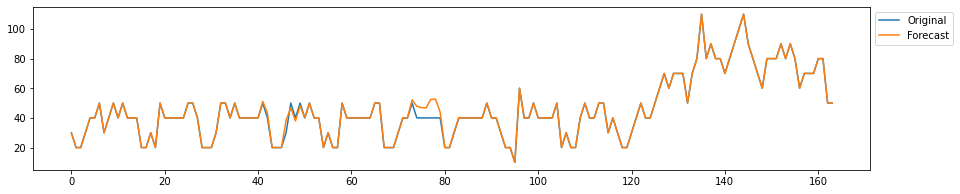

--------------------
training window 2628


/home/hugo/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


[ 18:27:47] getting statistics


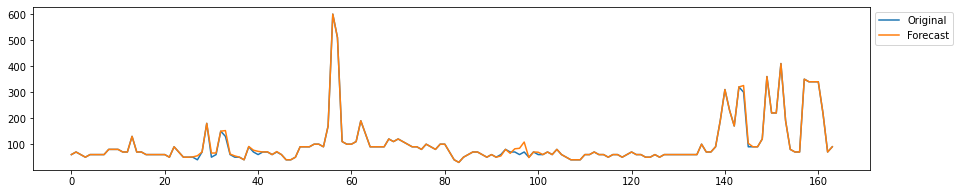

--------------------
training window 3285


/home/hugo/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


[ 18:27:48] getting statistics


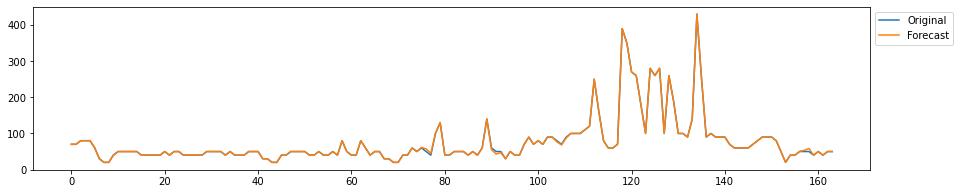

--------------------
training window 3942


/home/hugo/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


[ 18:27:49] getting statistics


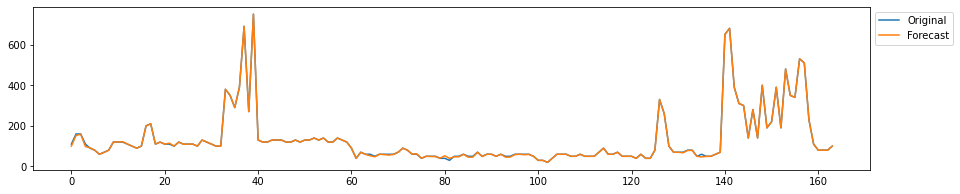

--------------------
training window 4599


/home/hugo/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


[ 18:27:50] getting statistics


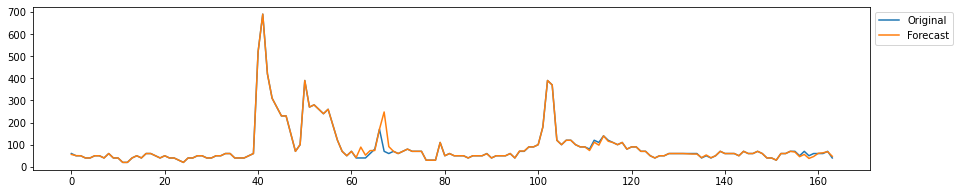

--------------------
training window 5256


/home/hugo/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


[ 18:27:51] getting statistics


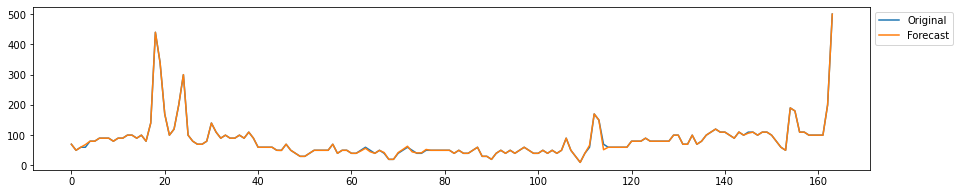

--------------------
training window 5913


/home/hugo/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


[ 18:27:51] getting statistics


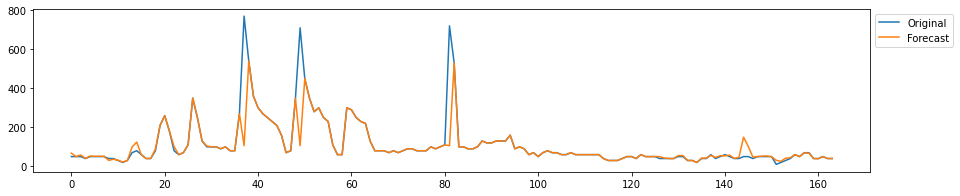

--------------------
training window 6570


/home/hugo/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


[ 18:27:52] getting statistics


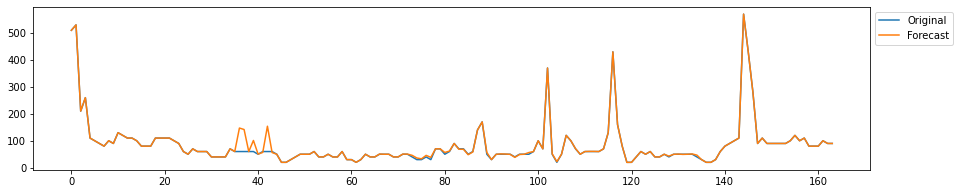

--------------------
training window 7227


/home/hugo/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


[ 18:27:53] getting statistics


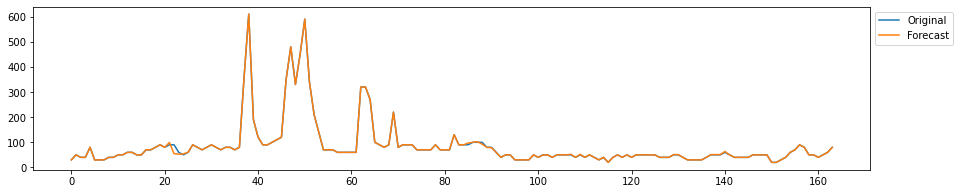

--------------------
training window 7884


/home/hugo/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


[ 18:27:54] getting statistics


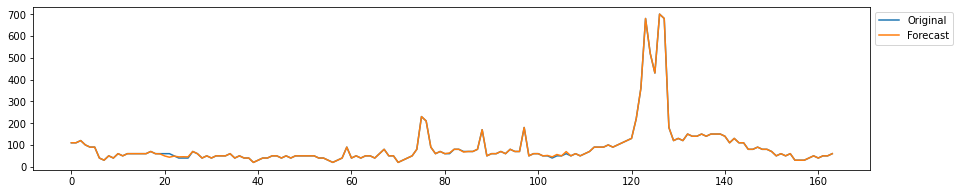

--------------------
training window 8541


/home/hugo/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


[ 18:27:54] getting statistics


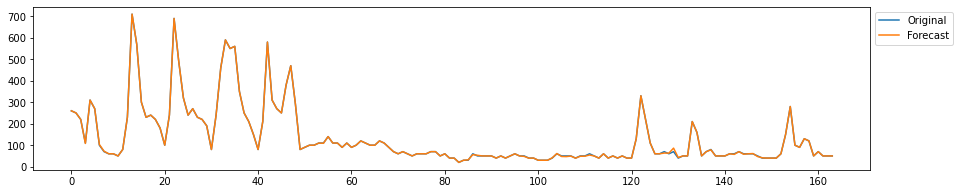

--------------------
training window 9198


/home/hugo/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


[ 18:27:55] getting statistics


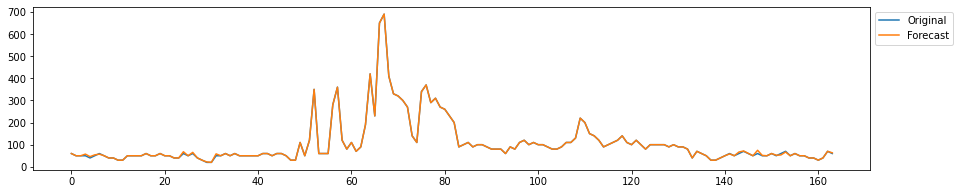

--------------------
training window 9855


/home/hugo/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


[ 18:27:56] getting statistics


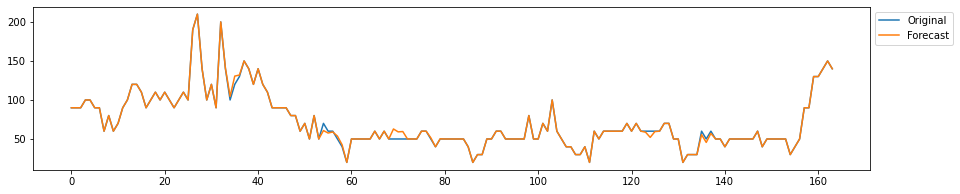

--------------------
training window 10512


/home/hugo/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


[ 18:27:57] getting statistics


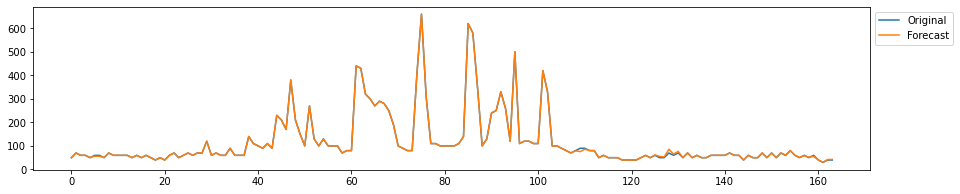

--------------------
training window 11169


/home/hugo/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


[ 18:27:58] getting statistics


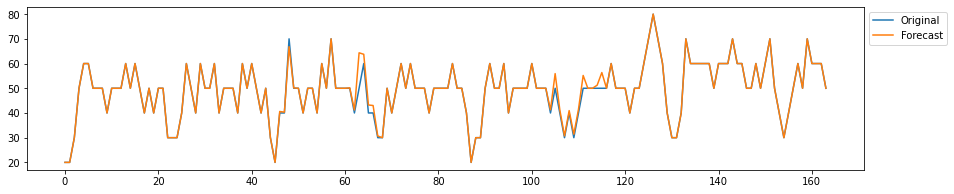

--------------------
training window 11826


/home/hugo/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


[ 18:27:59] getting statistics


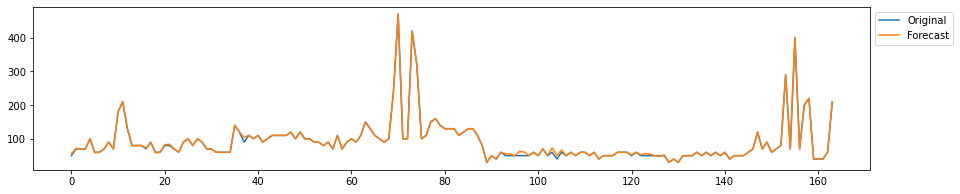

--------------------
training window 12483


/home/hugo/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


[ 18:28:00] getting statistics


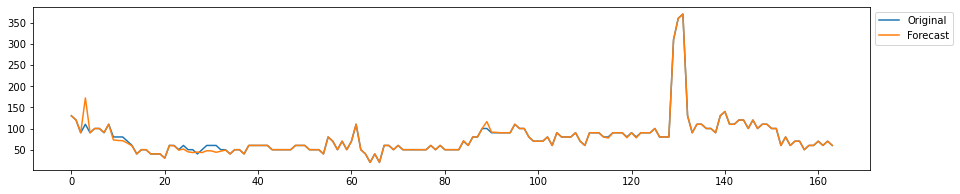

--------------------
training window 13140


/home/hugo/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


[ 18:28:01] getting statistics


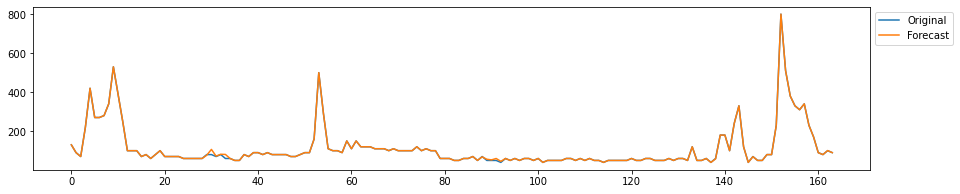

--------------------
training window 13797


/home/hugo/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


[ 18:28:01] getting statistics


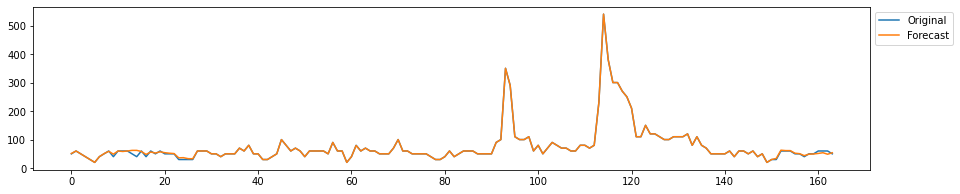

--------------------
training window 14454


/home/hugo/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


[ 18:28:02] getting statistics


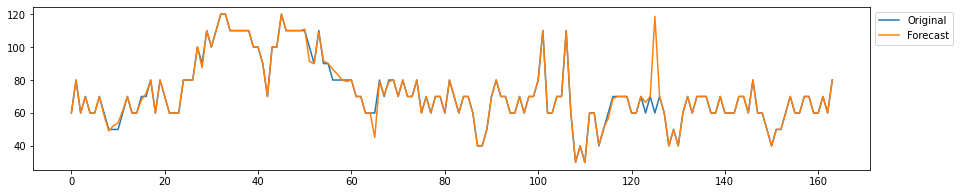

--------------------
training window 15111


/home/hugo/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


[ 18:28:03] getting statistics


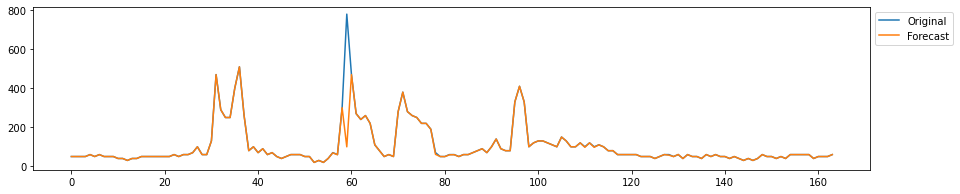

--------------------
training window 15768


/home/hugo/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


[ 18:28:04] getting statistics


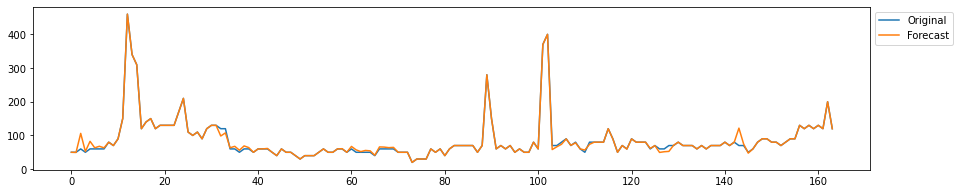

--------------------
training window 16425


/home/hugo/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


[ 18:28:04] getting statistics


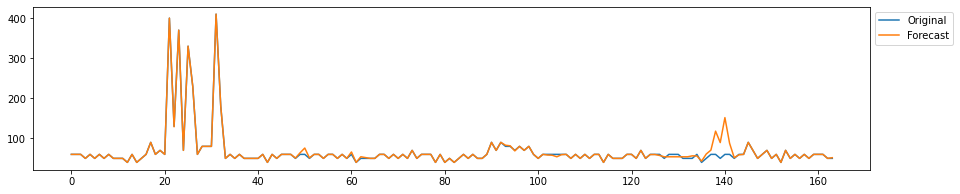

--------------------
training window 17082


/home/hugo/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


[ 18:28:06] getting statistics


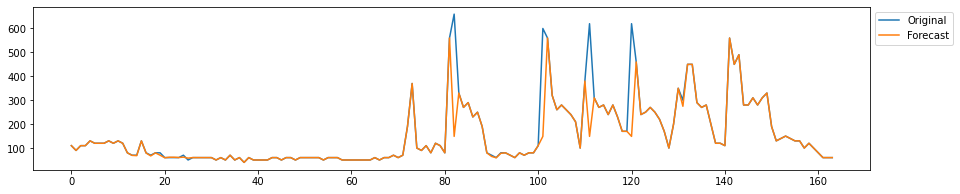

--------------------
training window 17739


/home/hugo/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


[ 18:28:07] getting statistics


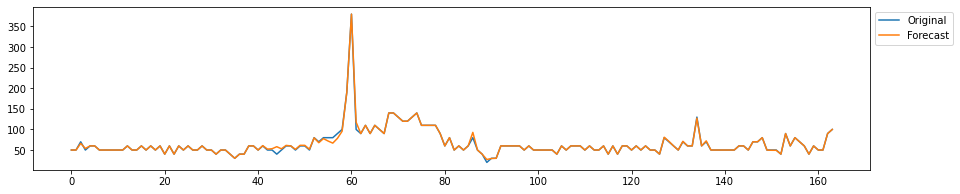

--------------------
training window 18396


/home/hugo/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


[ 18:28:08] getting statistics


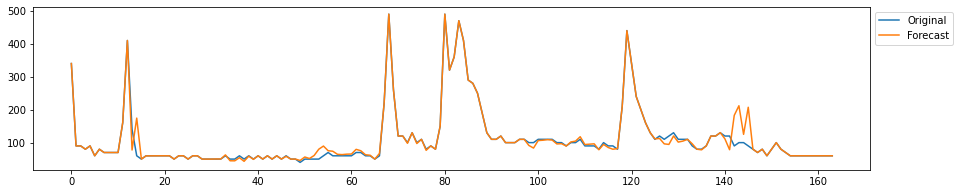

--------------------
training window 19053


/home/hugo/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


[ 18:28:08] getting statistics


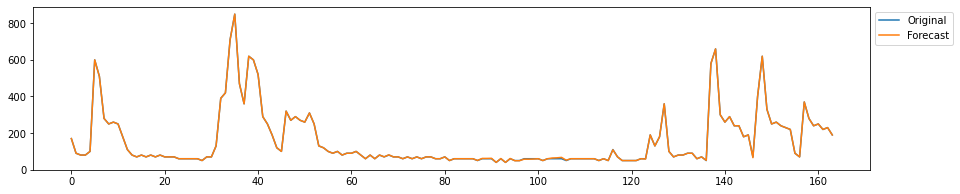

In [12]:
result = {
     "window": [],
     "rmse": [],
     "mape": [],
     "smape": [],
     "mae": []
}

order = 1
tam = len(data)
n_windows = 30
windows_length = math.floor(tam / n_windows)
for ct, ttrain, ttest in Util.sliding_window(data, windows_length, 0.75, inc=1):
    if len(ttest) > 0:
        
        data_train = ttrain.loc[:,'Appliances':'Tdewpoint']
        data_test = ttest.loc[:,'lights':'Appliances_t+1']
        
        data_test.rename(columns = {'Appliances_t+1': 'Appliances'}, inplace = True)
        
        #print(data_test)
        
        print('-' * 20)
        print(f'training window {(ct)}')
        model, pca_reduced_train = pca_wmvfts.run_train_model(data_train)
        forecast, forecast_self, pca_reduced_test = pca_wmvfts.run_test_model(model,data_test)
        
        #Teste e cálculo dos erros da previsão
        #appliance_test = ttest['Appliances_t+1'].values
                
        print("[{0: %H:%M:%S}]".format(datetime.datetime.now()) + f" getting statistics")
        rmse = Measures.rmse(pca_reduced_test['Appliances'],forecast)
        mape = Measures.mape(pca_reduced_test['Appliances'],forecast)
        smape = Measures.smape(pca_reduced_test['Appliances'],forecast)
        
        forecast = pd.DataFrame(forecast)
        forecast.fillna(forecast.mean(),inplace=True)
        forecast = np.array(forecast).reshape(-1)
        mae = mean_absolute_error(pca_reduced_test['Appliances'], forecast)
        
        # Grafico de comparação Original x Previsto para cada janela
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[15, 3])
        ax.plot(pca_reduced_test['Appliances'], label='Original')
        ax.plot(forecast, label='Forecast')
        handles, labels = ax.get_legend_handles_labels()
        lgd = ax.legend(handles, labels, loc=2, bbox_to_anchor=(1, 1))
        plt.show()
        
        result["rmse"].append(rmse)
        result["mape"].append(mape)
        result["smape"].append(smape)
        result["mae"].append(mae)
        result["window"].append(ct)
        
measures = pd.DataFrame(result)



In [13]:
measures

,window,rmse,mape,smape,mae
0,0,1.828248,0.548865,0.257151,0.322512
1,657,35.972175,2.189458,0.982261,3.868645
2,1314,0.579352,0.219243,0.108800,0.118103
3,1971,1.900959,1.141359,0.519046,0.448292
4,2628,5.189318,1.939669,0.856947,1.371018
5,3285,1.262301,0.568145,0.279272,0.301489
6,3942,2.403460,1.409436,0.699163,0.839535
7,4599,14.887263,4.065607,1.430880,2.458844
8,5256,1.860048,0.748338,0.382679,0.429258
9,5913,10.451746,6.394428,2.305166,14.160660


### Mean Statistics PCA-WMVFTS:

In [28]:
final_result = {
     "rmse": [],
     "mape": [],
     "smape": [],
      "mae": []
}

final_result["rmse"].append(statistics.mean(measures['rmse']))
final_result["mape"].append(statistics.mean(measures['mape']))
final_result["smape"].append(statistics.mean(measures['smape']))
final_result["mae"].append(statistics.mean(measures['smape']))

final_measures_pca = pd.DataFrame(final_result)

print("Mean Statistics PCA-WMVFTS (test): ")
final_measures_pca

Mean Statistics PCA-WMVFTS (test): 


,rmse,mape,smape,mae
0,5.456536,1.758168,0.745554,0.745554


In [15]:
# rmse	mape	smape	mae
# 4.878914	1.747223	0.741761	0.741761

### Extras 

In [16]:
pca_reduced_train

,C0,C1,Appliances
0,1.813411,-0.055305,60.0
1,1.810426,-0.054923,60.0
2,1.802639,-0.044817,50.0
3,1.791922,-0.012643,50.0
4,1.778163,-0.002661,50.0
...,...,...,...
488,-0.163267,-0.134241,820.0
489,-0.156863,-0.221025,350.0
490,-0.133445,-0.335024,300.0
491,-0.140448,-0.422090,260.0


In [17]:
print(model)

Weighted Multivariate FTS:
v047,v123,Appliances1 -> Appliances1 (0.5), Appliances2 (0.5)
v047,v123,Appliances2 -> Appliances1 (0.5), Appliances2 (0.5)
v047,v124,Appliances1 -> Appliances1 (0.5), Appliances2 (0.5)
v047,v124,Appliances2 -> Appliances1 (0.5), Appliances2 (0.5)
v048,v123,Appliances1 -> Appliances1 (0.5), Appliances2 (0.5)
v048,v123,Appliances2 -> Appliances1 (0.5), Appliances2 (0.5)
v048,v124,Appliances1 -> Appliances1 (0.5), Appliances2 (0.5)
v048,v124,Appliances2 -> Appliances1 (0.5), Appliances2 (0.5)
v047,v125,Appliances1 -> Appliances1 (0.5), Appliances2 (0.5)
v047,v125,Appliances2 -> Appliances1 (0.5), Appliances2 (0.5)
v048,v125,Appliances1 -> Appliances1 (0.5), Appliances2 (0.5)
v048,v125,Appliances2 -> Appliances1 (0.5), Appliances2 (0.5)
v046,v124,Appliances1 -> Appliances1 (0.5), Appliances2 (0.5)
v046,v124,Appliances2 -> Appliances1 (0.5), Appliances2 (0.5)
v046,v125,Appliances1 -> Appliances1 (0.5), Appliances2 (0.5)
v046,v125,Appliances2 -> Appliances1 (0.5),

In [18]:
# train = sample_first_prows(data,0.75)
# test = data.iloc[max(train.index):]
# y_test = data.iloc[max(train.index):]['Appliances_t+1'].values

In [19]:
# pca_wmvfts = PcaWeightedMVFTS(n_components = 2,
#                        endogen_variable = 'Appliances_t+1',
#                        n_part = 50)

In [20]:
# model, pca_reduced_train = pca_wmvfts.run_train_model(train)
# forecast, forecast_self, pca_reduced_test = pca_wmvfts.run_test_model(model,test)

In [21]:
#model.mvflrg

In [22]:
# forecast_1 = model.predict(pca_reduced_test)

In [23]:
# Measures.rmse(y_test,forecast)

In [24]:
# Measures.rmse(forecast_1,y_test)

In [25]:
# Measures.rmse(y_test,forecast_self)

In [26]:
# fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[15, 3])
# ax.plot(y_test, label='Original')
# ax.plot(forecast, label='Forecast')
# handles, labels = ax.get_legend_handles_labels()
# lgd = ax.legend(handles, labels, loc=2, bbox_to_anchor=(1, 1))
# plt.show()


In [27]:
# diff = data.loc[:,'lights':'Tdewpoint']
# diff = diff.diff()
# diff['Appliances'] = data['Appliances']
# data = diff.dropna()